In [80]:
## Imports
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import wavfile as wv
import torch
import torch.nn as nn
from tqdm import tqdm
from audioMNIST import AudioMNIST
from DClassifier import CNN2DAudioClassifier
from torch.utils.data import DataLoader, random_split

In [81]:
file_paths = './data/'

In [82]:
if torch.cuda.is_available():
    print("Using CUDA device")
    device = torch.device("cuda:0")
else:
    print("Using CPU")
    device = torch.device('cpu')

Using CPU


In [83]:
# Evaluation
def evaluate(model, val_dl): 
    running_loss = 0.0
    correct_prediction = 0
    total_prediction = 0
        
    for data in tqdm(val_dl):
        inputs, labels = data[0].to(device), data[1].to(device)

        inputs_m, inputs_s = inputs.mean(), inputs.std()
        inputs = (inputs - inputs_m) / inputs_s

        optimizer.zero_grad()

        outputs = model(inputs.to(device))
        loss = criterion(outputs, labels.to(device))

        running_loss += loss.item()

        _, prediction = torch.max(outputs, 1)
        correct_prediction += (prediction == labels).sum().item()
        total_prediction += prediction.shape[0]

    num_batches = len(val_dl)
    avg_loss = running_loss / num_batches
    acc = correct_prediction / total_prediction

    return acc, avg_loss

In [84]:
# Training
def training(model, train_dl, val_dl, num_epochs, 
             criterion, optimizer, scheduler):
    losses = []
    val_losses = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_prediction = 0
        total_prediction = 0
        
        for data in tqdm(train_dl):
            inputs, labels = data[0].to(device), data[1].to(device)
            
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s
            
            optimizer.zero_grad()
            
            outputs = model(inputs.to(device))
            loss = criterion(outputs, labels.to(device))
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            running_loss += loss.item()
            
            _, prediction = torch.max(outputs, 1)
            correct_prediction += (prediction == labels).sum().item()
            total_prediction += prediction.shape[0]
            
        num_batches = len(train_dl)
        avg_loss = running_loss / num_batches
        acc = correct_prediction / total_prediction
        
        v_acc, v_loss = evaluate(model.to(device), val_dl)
        
        print("Epoch: %d, Loss: %.4f, Train Accuracy: %.2f, Val. Loss: %.4f, Val. Accuracy: %.2f" % (
            epoch + 1, avg_loss, acc, v_loss, v_acc
        ))
        
        losses.append(avg_loss)
        val_losses.append(v_loss)
        
    return losses, val_losses

In [85]:
if __name__ == '__main__':
    model = CNN2DAudioClassifier().to(device)

    # dataset
    dataset = AudioMNIST()

    # 60-20-20 split
    n_total = len(dataset)
    n_train = int(n_total * 0.6)
    n_val = int(n_total * 0.2)
    n_test = n_total - n_train - n_val

    # Split the dataset
    train_ds, val_ds, test_ds = random_split(dataset, [n_train, n_val, n_test])

    # DataLoader instances
    train_dl = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=2)
    val_dl = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=2)
    test_dl = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=2)

In [86]:
N_EPOCHS = 4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                max_lr=0.001, 
                                                steps_per_epoch=int(len(train_dl)), 
                                                epochs=N_EPOCHS, 
                                                anneal_strategy='linear')

In [87]:
losses, val_losses = training(model, train_dl, val_dl, N_EPOCHS, criterion, optimizer, scheduler)

100%|██████████| 94/94 [00:24<00:00,  3.86it/s]


Epoch: 1, Loss: 1.5742, Train Accuracy: 0.50, Val. Loss: 0.6424, Val. Accuracy: 0.85


100%|██████████| 94/94 [00:24<00:00,  3.83it/s]


Epoch: 2, Loss: 0.2944, Train Accuracy: 0.94, Val. Loss: 0.1660, Val. Accuracy: 0.96


100%|██████████| 94/94 [00:24<00:00,  3.78it/s]


Epoch: 3, Loss: 0.1191, Train Accuracy: 0.97, Val. Loss: 0.1057, Val. Accuracy: 0.97


100%|██████████| 94/94 [00:28<00:00,  3.27it/s]

Epoch: 4, Loss: 0.0865, Train Accuracy: 0.98, Val. Loss: 0.0921, Val. Accuracy: 0.98


In [88]:
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

def final_evaluate(model, test_dl):
    model.eval()  # Ensure the model is in evaluation mode

    running_loss = 0.0
    correct_prediction = 0
    total_prediction = 0
    all_labels = []
    all_predictions = []

    for data in tqdm(test_dl):
        inputs, labels = data[0].to(device), data[1].to(device)

        # Normalize inputs
        inputs_m, inputs_s = inputs.mean(), inputs.std()
        inputs = (inputs - inputs_m) / inputs_s

        optimizer.zero_grad()

        with torch.no_grad():  # Ensure no gradients are computed in the forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        running_loss += loss.item()

        _, predictions = torch.max(outputs, 1)
        correct_prediction += (predictions == labels).sum().item()
        total_prediction += predictions.shape[0]

        # Collect all labels and predictions for confusion matrix
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predictions.cpu().numpy())

    num_batches = len(test_dl)
    avg_loss = running_loss / num_batches
    accuracy = correct_prediction / total_prediction
    f1_macro = f1_score(all_labels, all_predictions, average='macro')

    # Compute the confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=[0,1,2,3,4,5,6,7,8,9], yticklabels=[0,1,2,3,4,5,6,7,8,9])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    print(f"Accuracy: {accuracy:.4f}, Macro F1 Score: {f1_macro:.4f}, Average Loss: {avg_loss:.4f}")

    return accuracy, f1_macro, avg_loss

100%|██████████| 188/188 [00:26<00:00,  7.04it/s]


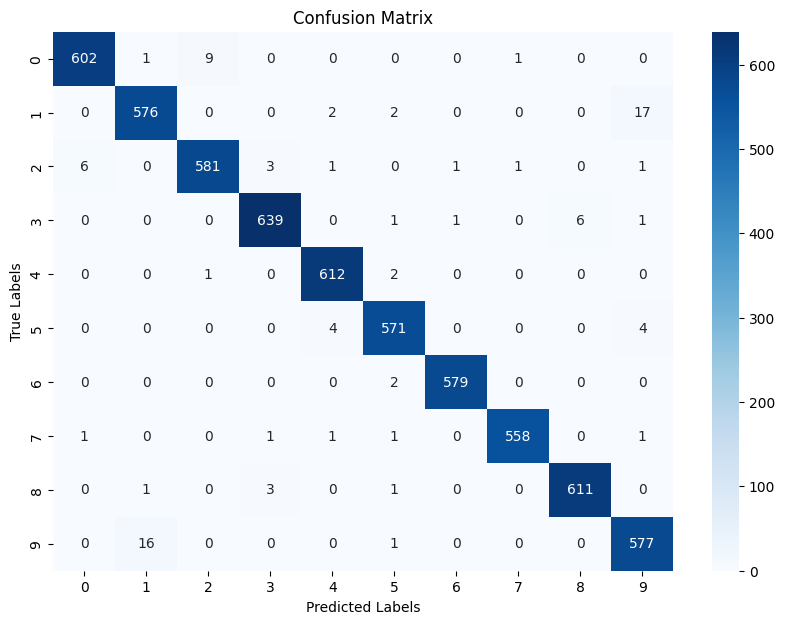

Accuracy: 0.9843, Macro F1 Score: 0.9843, Average Loss: 0.0724


(0.9843333333333333, 0.9843419692093848, 0.07237074068905984)

In [89]:
final_evaluate(model, test_dl)